## Датасет

[Students' Social Network Profile Clustering](https://www.kaggle.com/datasets/zabihullah18/students-social-network-profile-clustering/data) включает в себя случайную выборку из 15 000 учеников старших классов, которые вели профили на популярной платформе социальных сетей в период с 2006 по 2009 год. Данные собирались равномерно в течение этих лет.

Набор данных включает подсчеты 37 наиболее распространенных слов, найденных в профилях, таких как «футбол» и «шопинг», что указывает на распространенность различных тем среди учащихся.

Помимо данных, связанных с интересами, набор данных также включает важную демографическую информацию о каждом ученике, включая год окончания учебы (gradyear), пол, возраст на момент опроса и количество контактов или друзей, которые были у них в социальной сети (NumberOffriends)


In [97]:
!pip install optuna

In [98]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from itertools import product

In [99]:
import kagglehub

path = kagglehub.dataset_download("zabihullah18/students-social-network-profile-clustering")

print(os.listdir(path))
csv_path = os.path.join(path, "03_Clustering_Marketing.csv")
df = pd.read_csv(csv_path)

df.head()

['03_Clustering_Marketing.csv']


,gradyear,gender,age,NumberOffriends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2007,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2007,F,17.41,49,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,2007,F,17.511,41,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
3,2006,F,NaN,36,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2008,F,16.657,1,0,0,0,0,0,1,...,0,0,0,3,0,0,0,0,0,0


In [100]:
df.shape

(15000, 40)

## EDA

In [101]:
obj_types = df.select_dtypes(include='object').columns
print(obj_types)

Index(['gender', 'age'], dtype='object')


In [102]:
for obj in obj_types:
  print({i for i in df[obj]})



{nan, 'M', 'F'}
{'15.715', '15.548', '15.671', '19.006', '15.507', '17.739', '14.574', '17.013', '15.488', '16.257', '16.775', '16.545', '15.31', '17.495', '18.615', '17.958', '18.612', '18.393', '18.174', '15.521', '16.701', '17.919', '16.342', '18.218', '15.346', '15.992', '16.189', '17.35', '18.672', '15.91', '19.034', '18.951', '20.43', '15.463', '19.436', '16.107', '19.502', '19.452', '17.547', '14.943', '15.515', '15.061', '17.933', '18.204', '19.069', '16.619', '16.537', '19.83', '17.528', '16.517', '14-Aug', '45.331', '15.784', '18.752', '106.839', '16.156', '16.797', '17.366', '18.36', '14.979', '61.035', '15.532', '18.357', '16.682', '15. Mai', '16.966', '18.861', '17.355', '16.452', '17.856', '16.37', '18.155', '18.905', '17.161', '15.606', '18.073', '17.802', '16.263', '106.078', '16.033', '19.044', '17.257', '17.295', '16.413', '16.876', '15.225', '16.526', '18.831', '16.23', '18.133', '15. Jun', '16.953', '16.706', '17.032', '16.747', '15.65', '18.012', '15.847', '16.162'

### Перевод object типов gender и age

Как мы видим выше, в датасете только 2 столбца, представленных не в числовом формате. Перведём 'gender' колонку в уникальные идентификаторы с помощью методы pandas.

In [103]:
df['gender'], _ = pd.factorize(df['gender'])

Остался столбцец age, в котором есть как строки вида 18.Jul, так и средний возраст. Возможно при написании строки 18.Jul пользователи ошиблись и все строки такого вида сначала преобразуем в NaN, а затем заменим средним значением
по году выпуска.

In [104]:
df["age"] = pd.to_numeric(df["age"], errors="coerce")

In [105]:
df['age'] = df.groupby('gradyear')['age'].transform(lambda x: x.fillna(x.mean()))



---



In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gradyear         15000 non-null  int64  
 1   gender           15000 non-null  int64  
 2   age              15000 non-null  float64
 3   NumberOffriends  15000 non-null  int64  
 4   basketball       15000 non-null  int64  
 5   football         15000 non-null  int64  
 6   soccer           15000 non-null  int64  
 7   softball         15000 non-null  int64  
 8   volleyball       15000 non-null  int64  
 9   swimming         15000 non-null  int64  
 10  cheerleading     15000 non-null  int64  
 11  baseball         15000 non-null  int64  
 12  tennis           15000 non-null  int64  
 13  sports           15000 non-null  int64  
 14  cute             15000 non-null  int64  
 15  sex              15000 non-null  int64  
 16  sexy             15000 non-null  int64  
 17  hot         

In [107]:
df.describe()

,gradyear,gender,age,NumberOffriends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.00000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,2007.496933,0.084600,17.974626,29.834533,0.267000,0.255467,0.22200,0.159667,0.142933,0.135000,...,0.112867,0.259467,0.357267,0.150267,0.071800,0.051467,0.185867,0.118067,0.091733,0.061067
std,1.116516,0.505694,6.975129,35.386649,0.788851,0.702260,0.92042,0.737344,0.638747,0.548691,...,2.708619,0.704398,0.728512,0.478716,0.356258,0.280755,0.609928,0.455200,0.420631,0.349112
min,2006.000000,-1.000000,4.309000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2006.000000,0.000000,16.545000,3.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2008.000000,0.000000,17.466000,20.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2008.000000,0.000000,18.400134,44.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2009.000000,1.000000,106.927000,605.000000,22.000000,9.000000,22.00000,17.000000,14.000000,31.000000,...,327.000000,12.000000,11.000000,8.000000,8.000000,8.000000,16.000000,14.000000,8.000000,16.000000


*Из данных видно, что нам нужно будет масштабировать большинство числовых столбцов.*

In [108]:
df.duplicated().sum()

np.int64(280)

In [109]:
df.isnull().sum()

,0
gradyear,0
gender,0
age,0
NumberOffriends,0
basketball,0
football,0
soccer,0
softball,0
volleyball,0
swimming,0


NaN в датасете не осталось и есть немного дубликатов, скорее всего совпадения возраста.

In [110]:
len(df.head().columns)

40

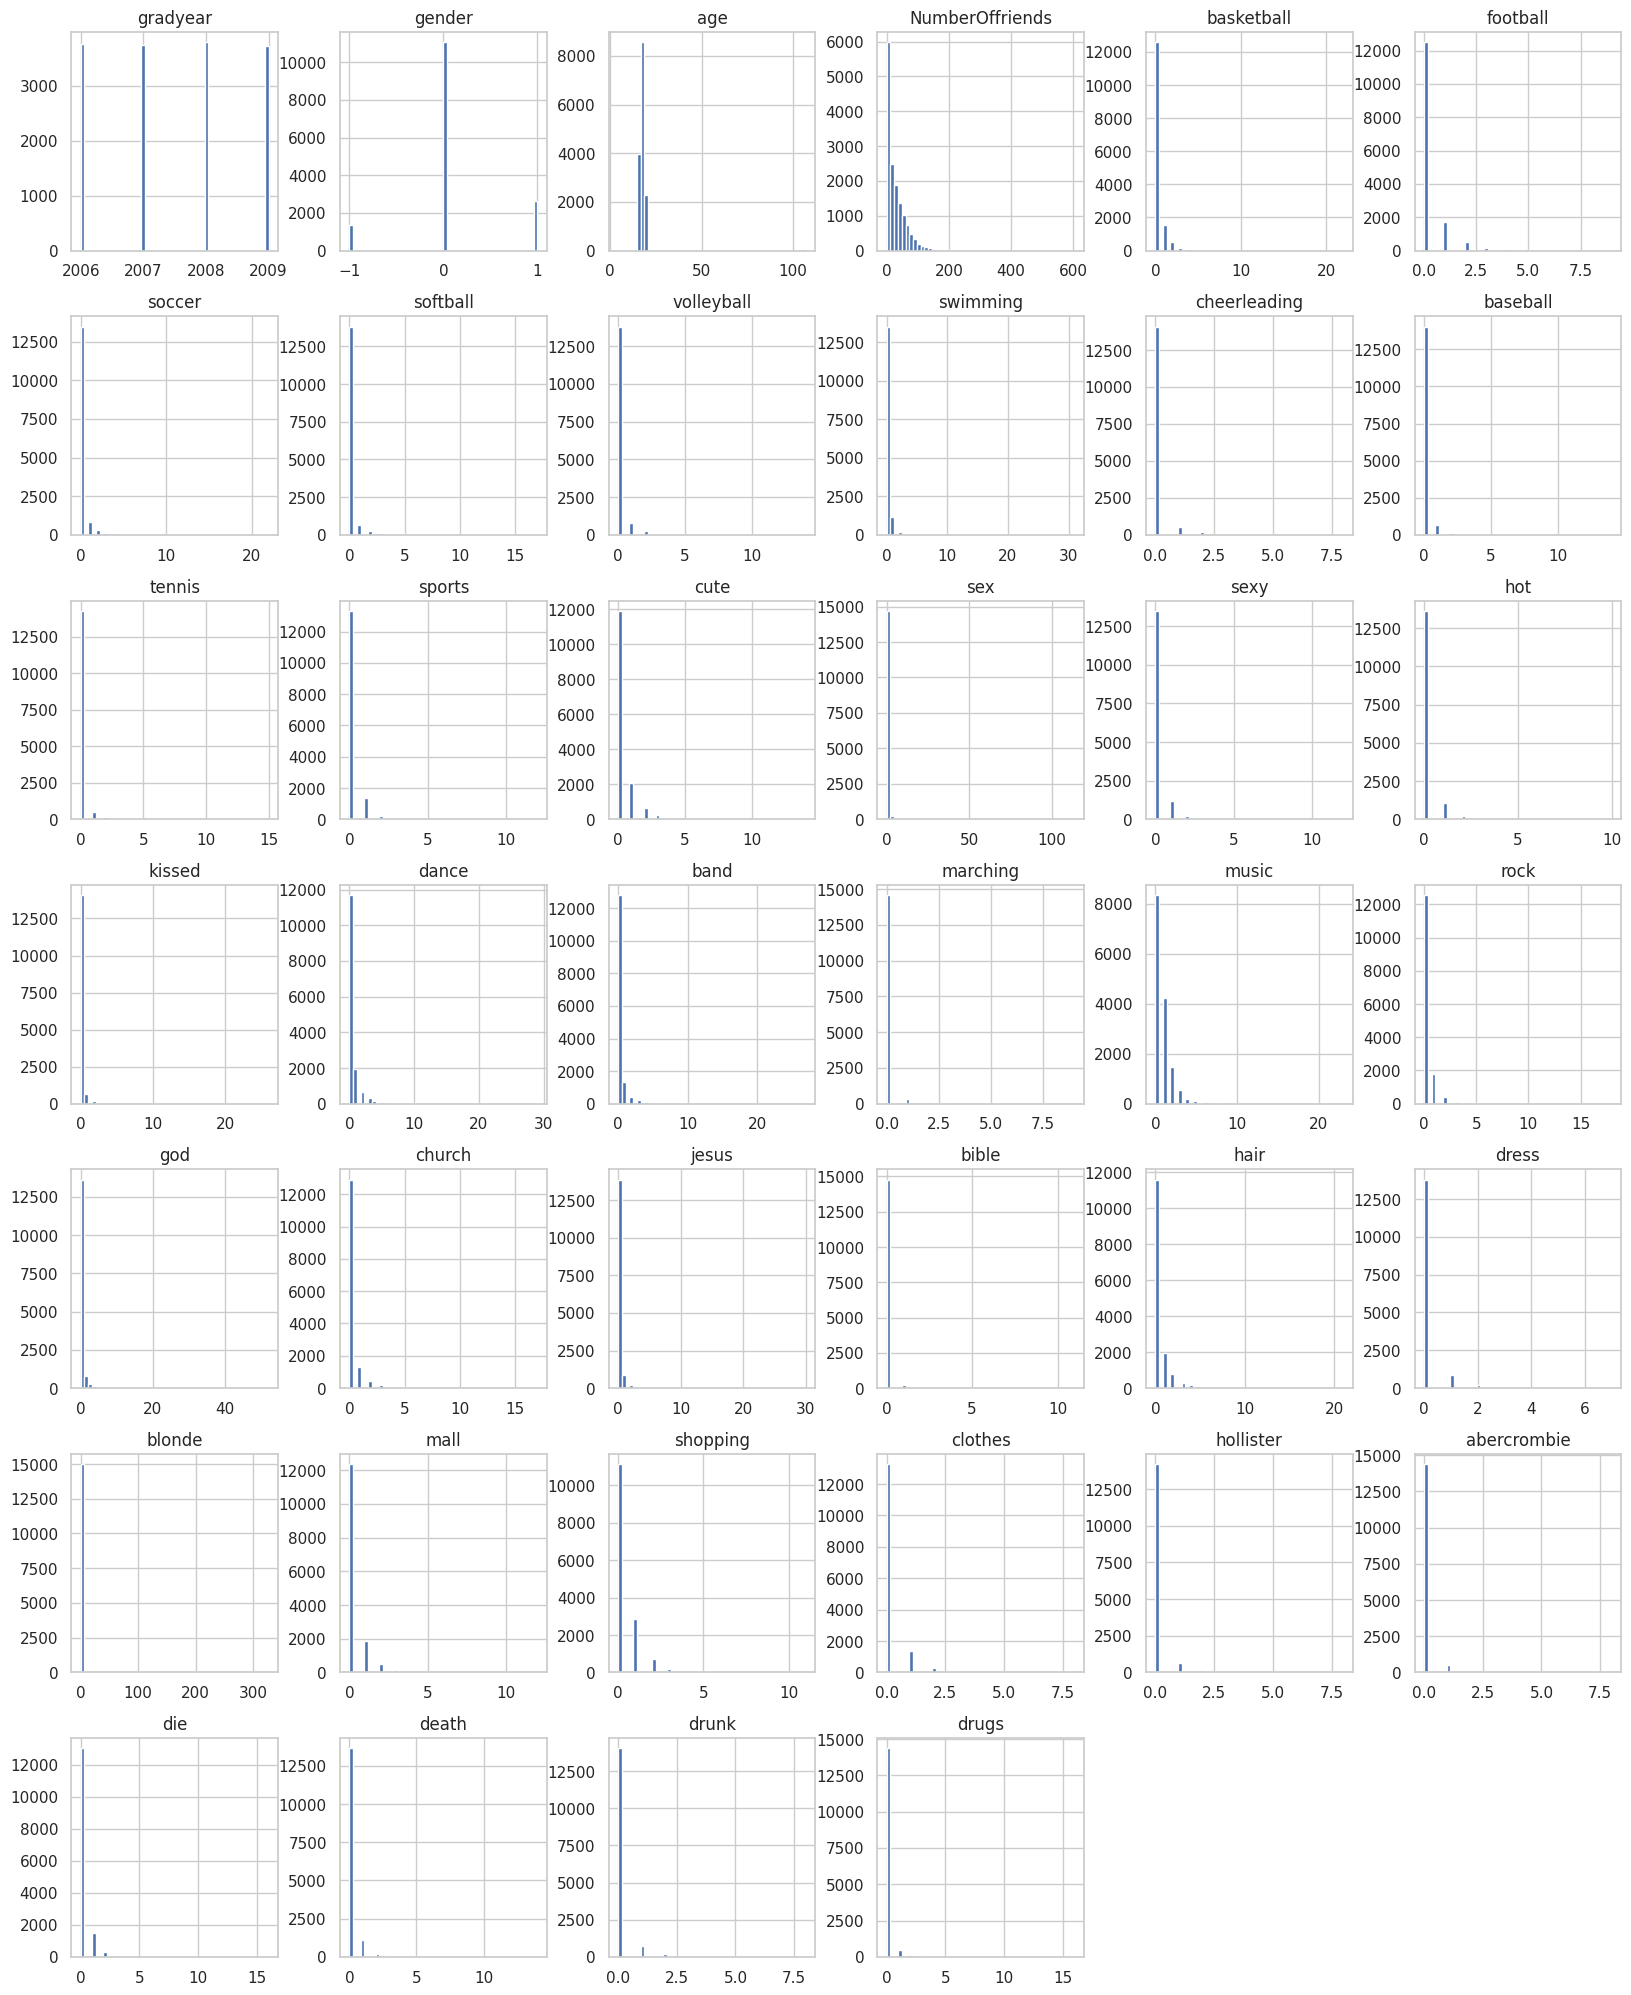

In [111]:
df.hist(figsize=(20, 25), bins = 50)
plt.show()

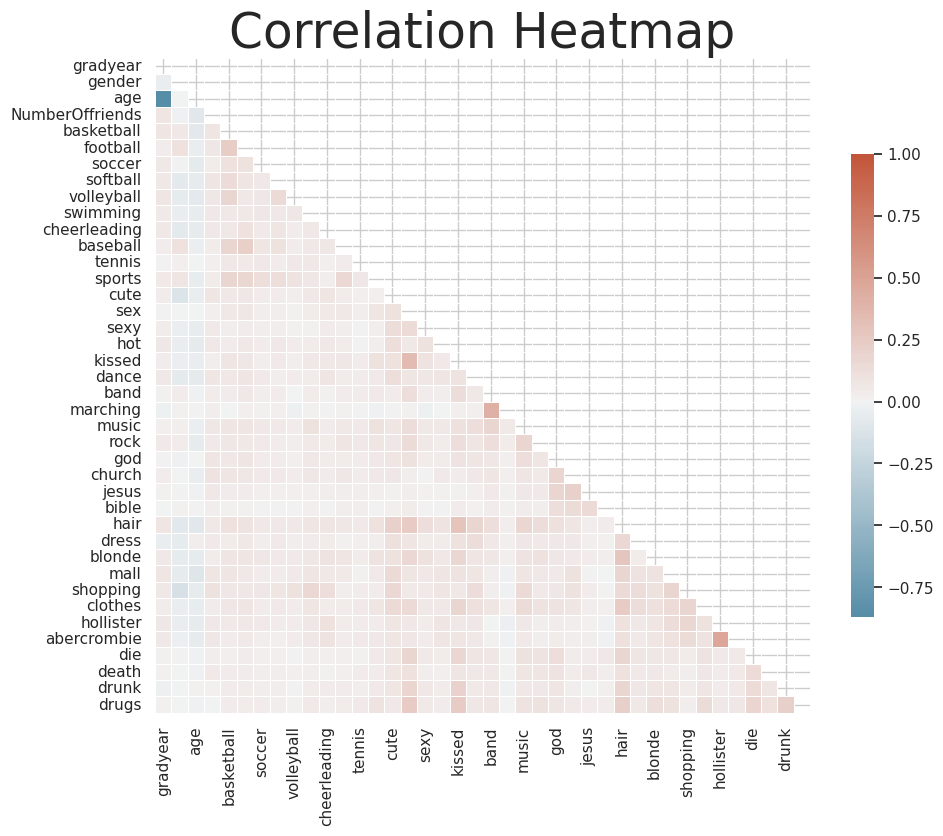

In [112]:
f,ax = plt.subplots(figsize=(10, 10))

mat = df.corr('spearman')
mask = np.triu(np.ones_like(mat,dtype=bool))
cmap = sns.diverging_palette(230,20,as_cmap=True)

sns.heatmap(mat,mask=mask,cmap=cmap,vmax=1,center=0,square=True,linewidths=.5,cbar_kws={"shrink":.5})

plt.title('Correlation Heatmap',fontsize=35)

plt.tight_layout()

plt.show()

Между объектами нет сильной корреляции. Никаких столбцов удалять не будем, однако перестрахуемся и удалим столбцы с низкой дисперсией.

#### Удалим столбцы с низкой дисперсией

In [113]:
from sklearn.feature_selection import VarianceThreshold
threshold = 0.1 # variance <= 0.1
selector = VarianceThreshold(threshold=threshold)

selector.fit(df)
mask = selector.get_support()
cols_to_keep = df.columns[mask]
df = df[cols_to_keep]

### Стандартизация набора входных данных

In [114]:
scaler = MinMaxScaler().fit(df)
features = scaler.transform(df)
pd.DataFrame(features, columns=df.columns).head()

,gradyear,gender,age,NumberOffriends,basketball,football,soccer,softball,volleyball,swimming,...,dress,blonde,mall,shopping,clothes,hollister,die,death,drunk,drugs
0,0.333333,0.0,0.137316,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.000,0.0000
1,0.333333,0.5,0.127668,0.080992,0.0,0.0,0.045455,0.0,0.0,0.032258,...,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.125,0.0000
2,0.333333,0.5,0.128652,0.067769,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.083333,0.0,0.000,0.0,0.0,0.0,0.125,0.0625
3,0.000000,0.5,0.143267,0.059504,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.000,0.0000
4,0.666667,0.5,0.120330,0.001653,0.0,0.0,0.000000,0.0,0.0,0.032258,...,0.0,0.0,0.000000,0.0,0.375,0.0,0.0,0.0,0.000,0.0000


## Elbow method

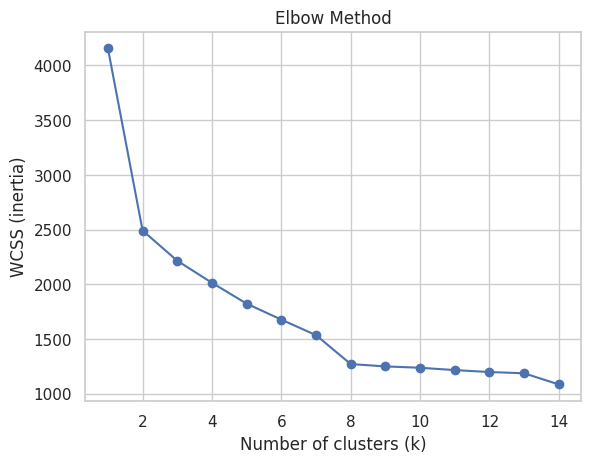

In [115]:
wcss = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 15), wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (inertia)')
plt.title('Elbow Method')
plt.show()

В графике выраженная точка изгиба, **число кластеров - (6 / 7 / 8)**.

## Davies–Bouldin index

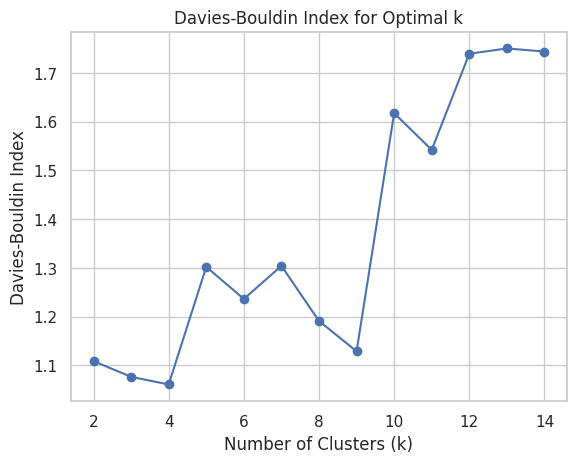

In [116]:
dbi_scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(features)
    dbi_scores.append(davies_bouldin_score(features, kmeans.labels_))

plt.plot(range(2, 15), dbi_scores, marker='o')
plt.title('Davies-Bouldin Index for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.show()

Пересекая результаты графиков, можно предположить, что лучше использовать **число кластеров - 4**

In [117]:
OPTIMAL_CLUSTER_NUM = 4

## PCA

In [118]:
X_train, X_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

In [119]:
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [120]:
def plot2d_show(data, title, labels=None):
    x, y = data[:, 0], data[:, 1]
    c = np.linspace(0, 1, len(data))  # Пример цветового градиента
    plt.figure(figsize=(8, 8))
    plt.scatter(x, y, c=c, alpha=1, s=10, cmap=plt.get_cmap('plasma'))
    plt.title(title)
    if labels is not None and len(labels) == 2:
        plt.xlabel(labels[0])
        plt.ylabel(labels[1])
    plt.show()

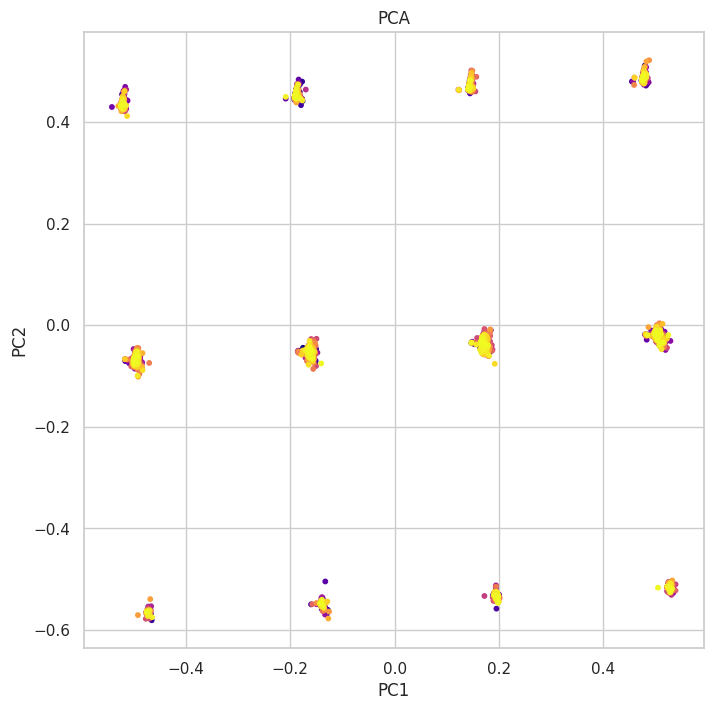

In [121]:
pca = PCA(random_state=42)
X_train_PCA = pca.fit_transform(X_train_scaled)
X_test_PCA = pca.transform(X_test_scaled)


plot2d_show(X_train_PCA, "PCA", ["PC1", "PC2"])

## t-SNE

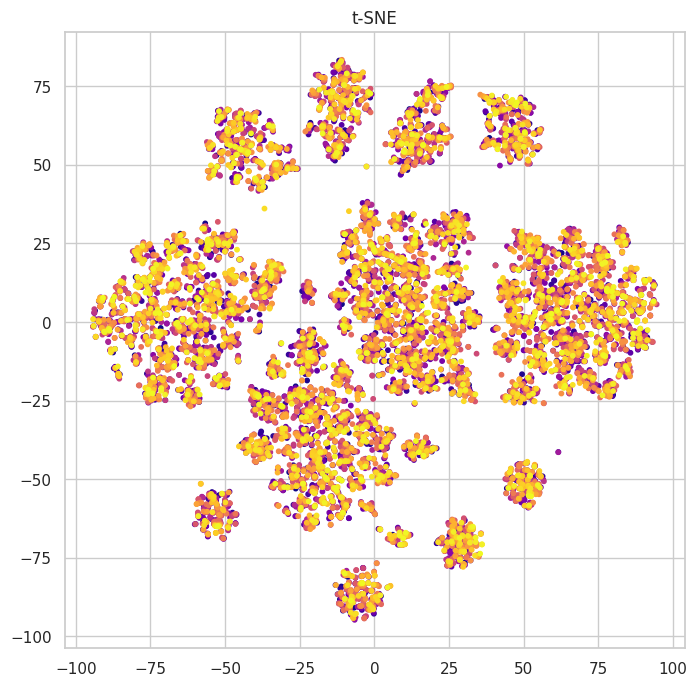

In [122]:
tsne = TSNE(random_state=42)
X_train_tsne = tsne.fit_transform(X_train_scaled)

plot2d_show(X_train_tsne, "t-SNE")

## Собственная реализация K-Means

In [123]:
class KMeansCustom(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=OPTIMAL_CLUSTER_NUM, max_iter=300, tol=1e-4, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

        self.centers = None

    def fit(self, X):
        X = np.array(X)
        np.random.seed(self.random_state)

        random_idxs = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centers = X[random_idxs]

        for _ in range(self.max_iter):
            clusters = self._assign_clusters(X)
            new_centers = []
            for j in range(self.n_clusters):
                points = X[clusters == j]
                if len(points) == 0:
                    new_centers.append(X[np.random.choice(len(X))])
                else:
                    new_centers.append(points.mean(axis=0))
            new_centers = np.array(new_centers)

            if np.linalg.norm(self.centers - new_centers) < self.tol:
                break
            self.centers = new_centers

        return self

    def predict(self, X):
        X = np.array(X)
        labels = self._assign_clusters(X)
        return labels

    def fit_predict(self, X, y=None):
        return self.fit(X).predict(X)

    def _assign_clusters(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centers, axis=2)
        return np.argmin(distances, axis=1)

### Подбор параметров

In [124]:
def run_test(objective):
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.BruteForceSampler())
    study.optimize(objective, n_trials=20)
    return study.best_params


def create_objective(model_class, fix_params, param_suggestions, train_dataset):
    def objective(trial):
        params = {**fix_params, **{k: v(trial, k) for k, v in param_suggestions.items()}}
        model = model_class(**params)
        cv = KFold(n_splits=5, shuffle=True)

        cv_scores = cross_val_score(
                model,
                train_dataset,
                cv=cv,
                scoring=lambda model, X: silhouette_score(X, model.fit_predict(X)),
                n_jobs=-1)

        return cv_scores.mean()
    return objective

max_iter_suggestion = lambda t, k: t.suggest_categorical(k, [100 * i for i in range(1, 10)])

param_suggestions = {
    "customKMeans": {"max_iter": max_iter_suggestion},
    "kmeans": {
        "max_iter": max_iter_suggestion,
        "init": lambda t, k: t.suggest_categorical(k, ['random', 'k-means++'])
    },
    "DBSCAN": {
        "eps": lambda t, k: t.suggest_categorical(k, [0.1 * i for i in range(1, 11)]),
        "min_samples": lambda t, k: t.suggest_categorical(k, [i for i in range(2, 10)]),
    }
}

fix_params = {
    "customKMeans": {"n_clusters": 10, "tol": 1e-4},
    "kmeans": {"n_clusters": 10, "tol": 1e-4},
    "DBSCAN": {}
}

pre_objects = {
    "customKMeans": KMeansCustom,
    "kmeans": KMeans,
    "DBSCAN": DBSCAN,
}

def create_objects(pre_objects = pre_objects):

  res = {}
  for k, v in pre_objects.items():
    non_pca_name = f"{k}-non-pca"

    res[k] = {}
    res[k]["non-pca"] = create_objective(v, fix_params[k], param_suggestions[k], X_train)
    res[k]["pca"] = create_objective(v, fix_params[k], param_suggestions[k], X_train_PCA)

  return res


### Узнаем лучшие параметры с помощью Optune

In [125]:
objs = create_objects()

best_params = {}
for algoName, value_map in objs.items():
    best_params[algoName] = {}
    for pca_flag, obj in value_map.items():
        best_params[algoName][pca_flag] = run_test(obj)


<ipython-input-124-3790095496>:2: ExperimentalWarning: BruteForceSampler is experimental (supported from v3.1.0). The interface can change in the future.
  study = optuna.create_study(direction="maximize", sampler=optuna.samplers.BruteForceSampler())
[I 2025-06-12 18:23:29,839] A new study created in memory with name: no-name-3cac03a1-a8f7-4566-b5ae-8cbab46431e9
[I 2025-06-12 18:23:41,508] Trial 0 finished with value: 0.39078212615900787 and parameters: {'max_iter': 700}. Best is trial 0 with value: 0.39078212615900787.
[I 2025-06-12 18:23:52,280] Trial 1 finished with value: 0.40680537323283056 and parameters: {'max_iter': 300}. Best is trial 1 with value: 0.40680537323283056.
[I 2025-06-12 18:24:01,810] Trial 2 finished with value: 0.3881259796284226 and parameters: {'max_iter': 900}. Best is trial 1 with value: 0.40680537323283056.
[I 2025-06-12 18:24:08,926] Trial 3 finished with value: 0.3595401457024926 and parameters: {'max_iter': 200}. Best is trial 1 with value: 0.406805373232

#### Лучшие параметры для customKMeans

In [127]:
print(best_params['customKMeans'])

{'non-pca': {'max_iter': 600}, 'pca': {'max_iter': 300}}


#### Лучшие параметры для KMeans

In [128]:
print(best_params['kmeans'])

{'non-pca': {'max_iter': 200, 'init': 'k-means++'}, 'pca': {'max_iter': 900, 'init': 'random'}}


#### Лучшие параметры для DBSCAN

In [129]:
print(best_params['DBSCAN'])

{'non-pca': {'eps': 0.6000000000000001, 'min_samples': 4}, 'pca': {'eps': 0.9, 'min_samples': 6}}


## Сравнение моделей

In [130]:
def get_model_score(model, X_train, dbscan=False):
    scores = {}
    start = datetime.now()
    if dbscan:
        labels = model.fit_predict(X_train)
    else:
        model.fit(X_train)
        labels = model.predict(X_train)

    end = datetime.now()
    elapsed_time = (end - start).total_seconds()

    silhouette = silhouette_score(X_train, labels)
    calinski_harabasz = calinski_harabasz_score(X_train, labels)

    scores['training_time'] = elapsed_time
    scores['silhouette'] = silhouette
    scores['calinski_harabasz'] = calinski_harabasz

    return scores


In [131]:
def get_best_params_model(best_params):
    res = {}

    for algoName, value_map in best_params.items():
        res[algoName] = {}
        if algoName.startswith("customKMeans"):
            for pca_flag, best_params in value_map.items():
                res[algoName][pca_flag] = KMeansCustom(**best_params)
        elif algoName.startswith("kmeans"):
            for pca_flag, best_params in value_map.items():
                res[algoName][pca_flag] = KMeans(n_clusters=OPTIMAL_CLUSTER_NUM, **best_params)
        elif algoName.startswith("DBSCAN"):
            for pca_flag, best_params in value_map.items():
                res[algoName][pca_flag] = DBSCAN(**best_params)
        else:
            print("Not supported", k)

    return res


In [132]:
models = get_best_params_model(best_params)


results = {}
for algoName, value_map in models.items():
    results[algoName] = {}
    dbScanFlag = False
    if algoName == "DBSCAN":
        dbScanFlag = True

    for pca_flag, model in value_map.items():
        if pca_flag == "pca":
            results[algoName][pca_flag] = get_model_score(model, X_train_PCA, dbscan=dbScanFlag)
        elif pca_flag == "non-pca":
            results[algoName][pca_flag] = get_model_score(model, X_train, dbscan=dbScanFlag)


### Графики

In [133]:
def results_to_df(data):
    records = []
    for model, configs in data.items():
        for pca_flag, metrics in configs.items():
            records.append({
                'model': model,
                'pca': pca_flag,
                **metrics
            })

    return pd.DataFrame.from_records(records)

In [134]:
def show_all_plots(final_df):
    plt.figure(figsize=(10, 15))

    sns.set_theme(style="whitegrid")

    plt.subplot(3, 1, 1)
    sns.barplot(x='model', y='silhouette', hue='pca', data=final_df)
    plt.title('Сравнение silhouette score')
    plt.ylim(0, 1)

    plt.subplot(3, 1, 2)
    sns.barplot(x='model', y='calinski_harabasz', hue='pca', data=final_df)
    plt.title('Сравнение calinski_harabasz')

    plt.subplot(3, 1, 3)
    sns.barplot(x='model', y='training_time', hue='pca', data=final_df)
    plt.title('Сравнение времени обучения')

    plt.tight_layout()
    plt.show()


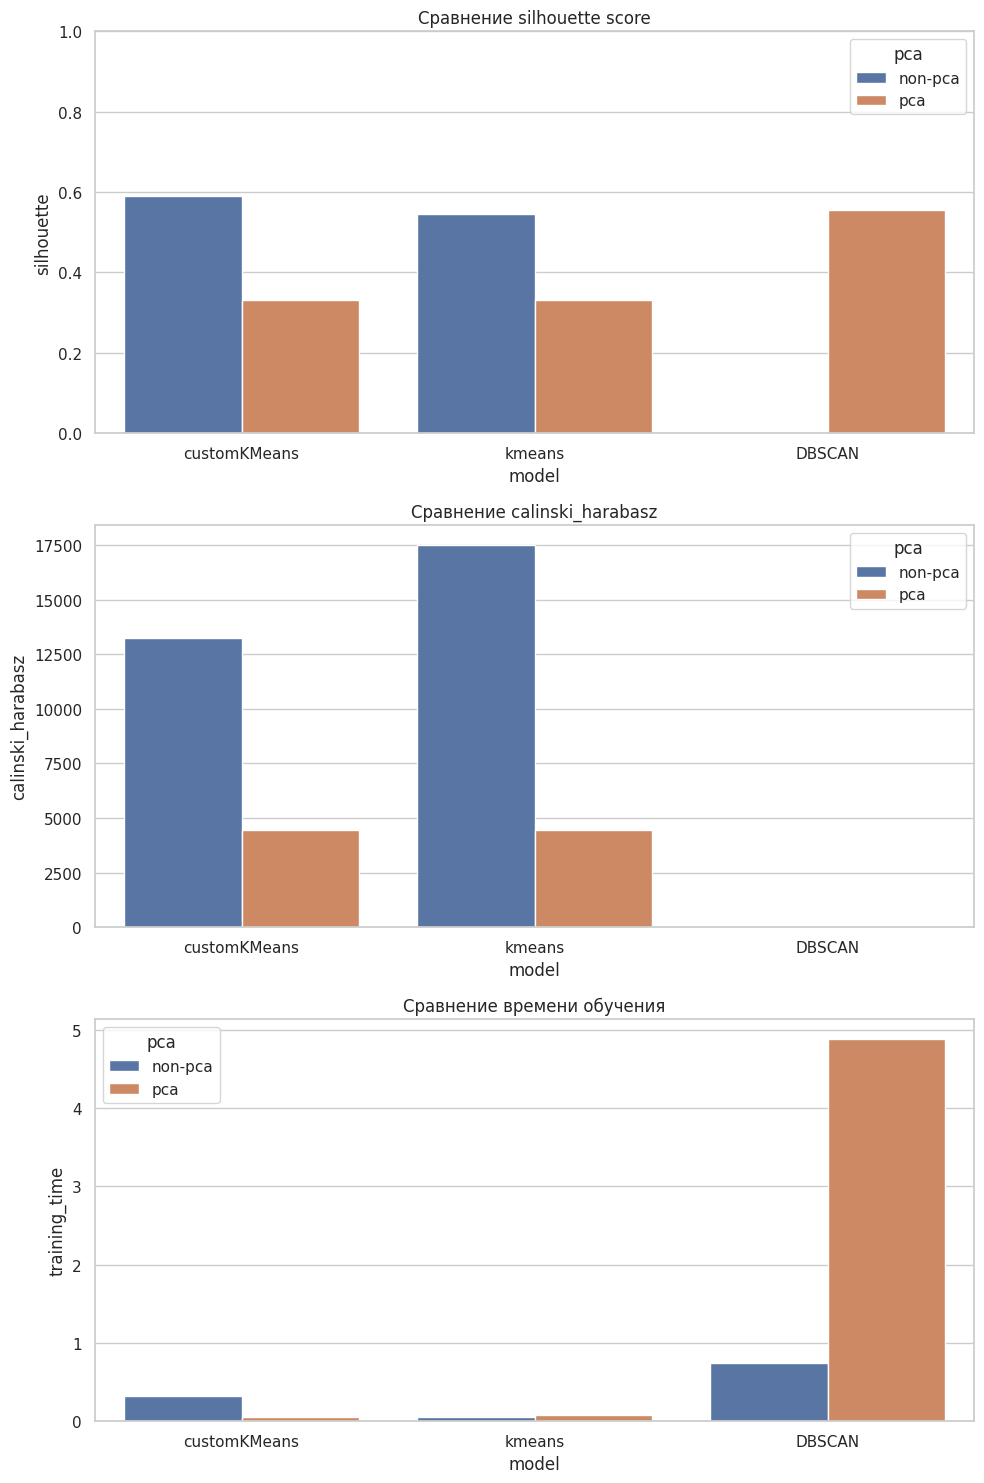

In [135]:
df = results_to_df(results)

show_all_plots(df)

### Выводы

По скорости обучения наименьшее время показывает стандартный KMeans без применения PCA (≈0.06 с), далее идёт KMeans с PCA (≈0.096 с), затем собственная реализация KMeans без PCA (≈0.325 с) и с PCA (≈0.404 с). Алгоритм DBSCAN при любом подходе заметно медленнее: без PCA ≈0.77 с, с PCA ≈5.67 с.

Если оценивать качество разбиения, то по силе силуэта лидирует собственный KMeans без PCA (0.589), чуть отстаёт DBSCAN с PCA (0.555) и стандартный KMeans без PCA (0.546), а наихудшие показатели у всех видов с PCA (~0.332) и у DBSCAN без PCA (−0.527). По индексу Калински—Харабаша лучший снова стандартный KMeans без PCA (≈17533), затем собственный KMeans без PCA (≈13264), у всех вариантов с PCA одинаково ≈4450, а у DBSCAN самые низкие значения (≈11 без PCA и ≈33 с PCA).

DBSCAN чувствителен к выбору параметров ε и min_samples: если плотности кластеров в данных сильно различаются или границы сглажены, многие точки могут оказаться помечены как шум, а реально близкие группы — слиты в один кластер, отчего силуэт получается плохим или вовсе отрицательным.